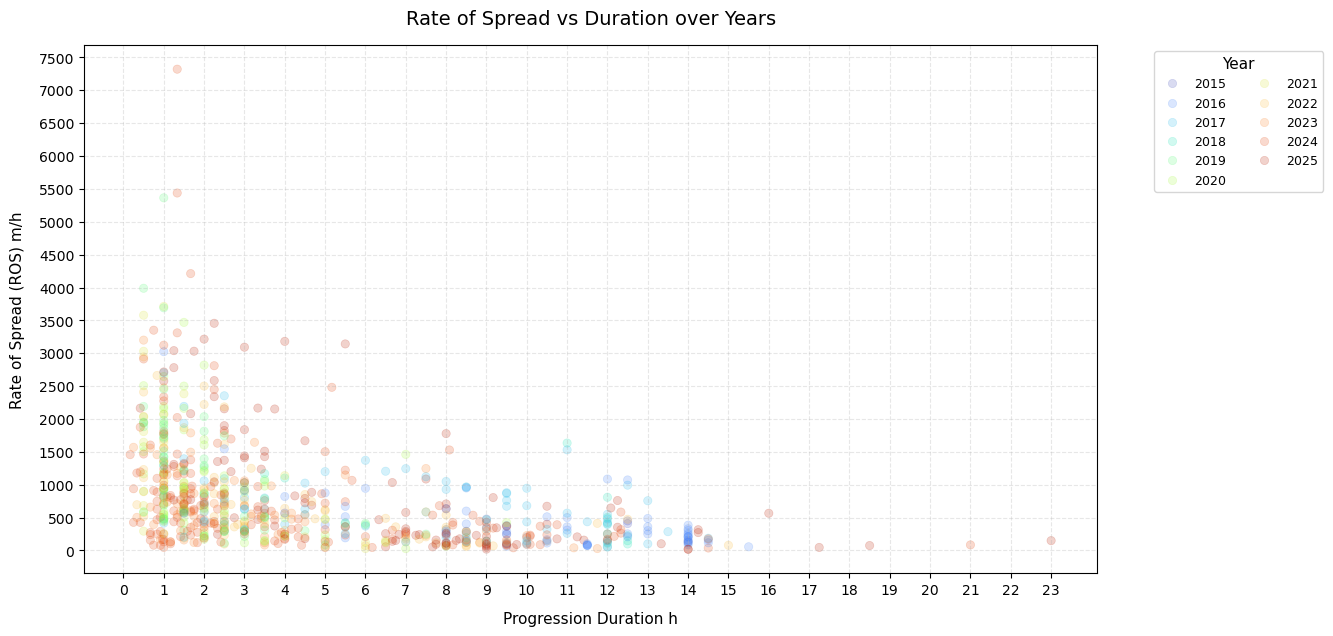

In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

# Caminho do shapefile baseado no modelo
shapefile_path = r"..\..\..\Data\Processed\PT-FireSprd_v3.0\L2_FireBehavior\PT-FireSprd_v3.0_L2_short.shp"

# Ler o shapefile
df = gpd.read_file(shapefile_path)

# Filtrar apenas os anos desejados
anos = list(range(2015, 2026))
df_filtered = df[df['year'].isin(anos)].copy()

# 👉 FORÇAR year COMO CATEGÓRICO PARA LEGENDAS COMPLETAS
df_filtered['year'] = df_filtered['year'].astype(str)
hue_order = sorted(df_filtered['year'].unique(), key=int)

plt.figure(figsize=(14, 7))
ax = plt.gca()

sns.scatterplot(
    data=df_filtered,
    x='duration_p',
    y='ros_p',
    hue='year',
    palette='turbo',   # mantido
    alpha=0.2,
    edgecolor=None,
    ax=ax,
    hue_order=hue_order,
)

# Título e labels com padding consistente
ax.set_title(
    'Rate of Spread vs Duration over Years',
    fontsize=14,
    pad=15
)
ax.set_xlabel(
    'Progression Duration h',
    fontsize=11,
    labelpad=10
)
ax.set_ylabel(
    'Rate of Spread (ROS) m/h',
    fontsize=11,
    labelpad=10
)

# Grid no mesmo estilo dos outros plots
ax.grid(
    True,
    linestyle='--',
    alpha=0.3
)

# Ajuste de ticks
ax.xaxis.set_major_locator(MaxNLocator(nbins=8))
ax.yaxis.set_major_locator(MaxNLocator(nbins=8))

plt.xticks(np.arange(0, df_filtered['duration_p'].max()+1, step=1))
plt.yticks(np.arange(0, df_filtered['ros_p'].max()+200, step=500))

# Legenda completa com todos os anos
ax.legend(
    title='Year',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    ncol=2,
    frameon=True,
    fontsize=9,
    title_fontsize=11
)

plt.tight_layout(pad=3.0)
plt.show()


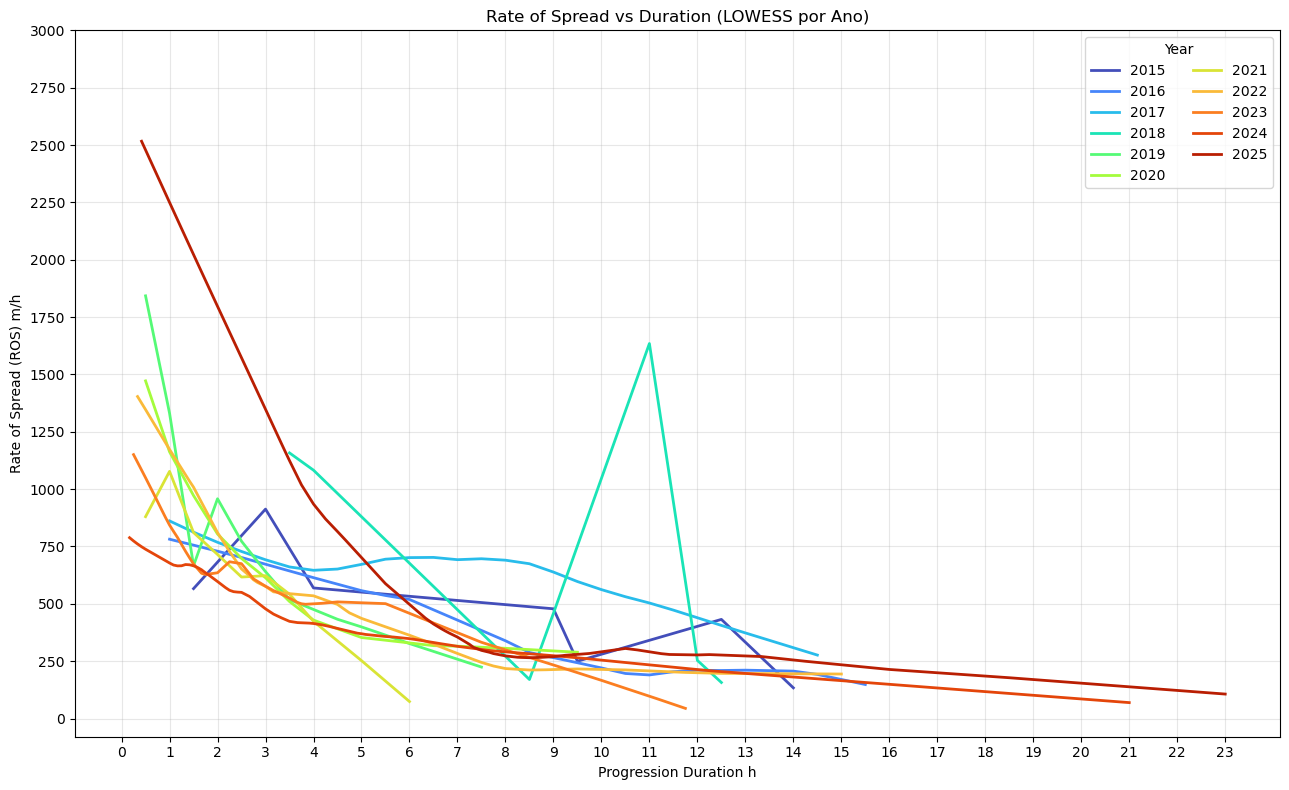

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess

anos = sorted(df_filtered['year'].unique())
cores = sns.color_palette("turbo", n_colors=len(anos))

plt.figure(figsize=(13,8))

for i, ano in enumerate(anos):
    df_ano = df_filtered[df_filtered['year'] == ano].copy()
    
    # Ordena para LOWESS funcionar corretamente
    df_ano = df_ano.sort_values('duration_p')
    
    # LOWESS robusto diretamente no ROS
    lowess_res = lowess(
        endog=df_ano['ros_p'],        # ROS original
        exog=df_ano['duration_p'],
        frac=0.5,
        it=7
    )
    
    # Curva suavizada
    plt.plot(
        lowess_res[:, 0],
        lowess_res[:, 1],
        color=cores[i],
        lw=2,
        label=str(ano)
    )

plt.title('Rate of Spread vs Duration (LOWESS por Ano)')
plt.xlabel('Progression Duration h')
plt.xticks(np.arange(0, df_filtered['duration_p'].max()+1, step=1))
plt.yticks(np.arange(0, 3001, step=250))
plt.ylabel('Rate of Spread (ROS) m/h')
plt.grid(alpha=0.3)
plt.legend(title='Year', ncol=2)
plt.tight_layout()
plt.show()


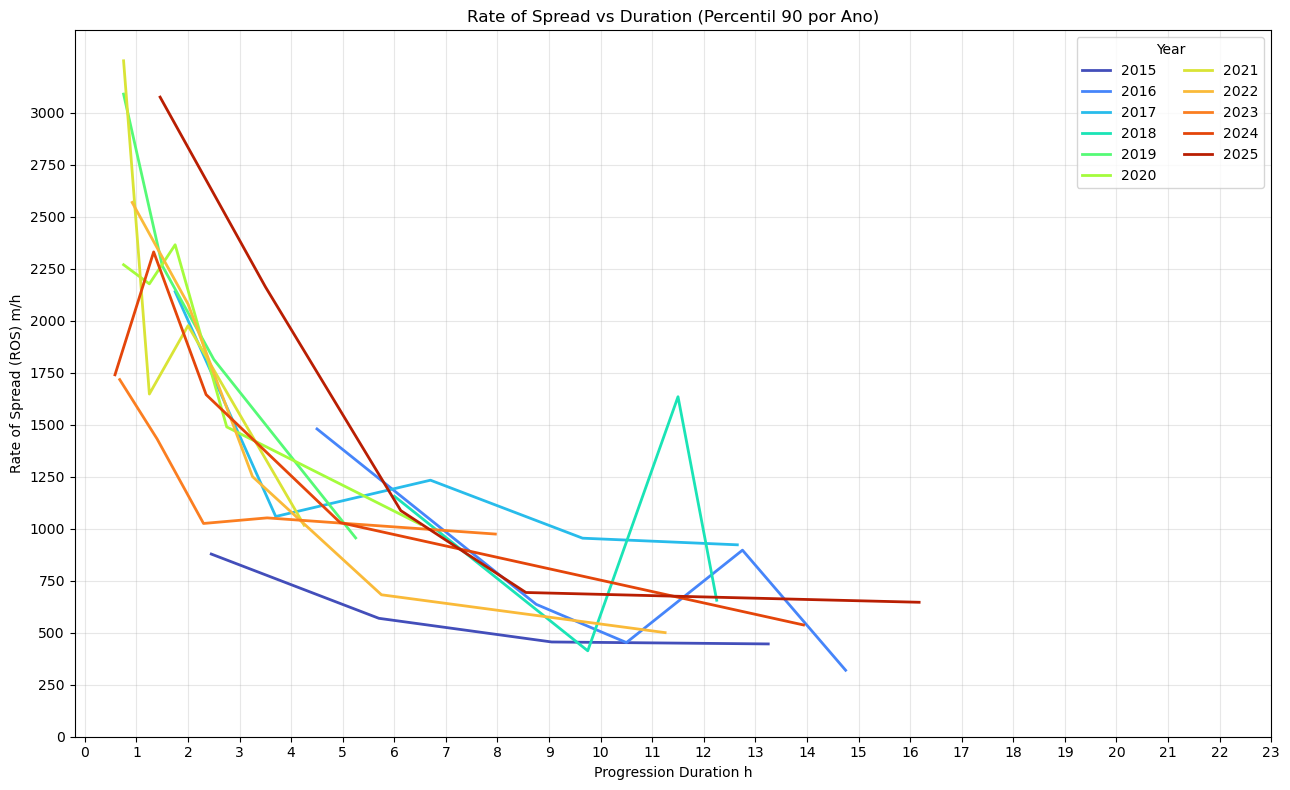

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Anos únicos e cores
anos = sorted(df_filtered['year'].unique())
cores = sns.color_palette("turbo", n_colors=len(anos))

plt.figure(figsize=(13,8))

for i, ano in enumerate(anos):
    df_ano = df_filtered[df_filtered['year'] == ano].copy()
    
    # Ordena por duration_p
    df_ano = df_ano.sort_values('duration_p')
    
    # Criar 8 bins quantílicos
    bins = np.quantile(df_ano['duration_p'], np.linspace(0, 1, 6))
    
    # Calcula o percentil 90 em cada bin
    bin_centers = []
    perc90_values = []
    
    for j in range(len(bins)-1):
        bin_mask = (df_ano['duration_p'] >= bins[j]) & (df_ano['duration_p'] < bins[j+1])
        bin_data = df_ano.loc[bin_mask, 'ros_p']
        if len(bin_data) > 0:
            perc90_values.append(np.percentile(bin_data, 90))
            bin_centers.append((bins[j] + bins[j+1])/2)
    
    # Plota a curva do percentil 90
    plt.plot(
        bin_centers,
        perc90_values,
        color=cores[i],
        lw=2,
        label=str(ano)
    )

plt.title('Rate of Spread vs Duration (Percentil 90 por Ano)')
plt.xlabel('Progression Duration h')
plt.xticks(np.arange(0, df_filtered['duration_p'].max()+1, step=1))
plt.yticks(np.arange(0, 3001, step=250))
plt.ylabel('Rate of Spread (ROS) m/h')
plt.grid(alpha=0.3)
plt.legend(title='Year', ncol=2)
plt.tight_layout()
plt.show()
